## Machine Learning Breast Cancer Detection

Breast cancer is one of the most common cancer in the world. IDC is one of the representative breast cancer(80% breast cancer is IDC). So, detect if the breast cancer is IDC can be one of the most important method to justify breast cancer.

### 1. Import

In [1]:
import numpy as np
import matplotlib.pylab as plt
import itertools

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### 2. Data analysis

Shuffle original datasets

In [2]:
X = np.load('data/X.npy') # load image
Y = np.load('data/Y.npy') # load label (0 = not IDC, 1 = IDC)

In [3]:
from sklearn.utils import shuffle

x_shuffle_test = np.array([[11, 10], [212, 10], [5, 6]])
y_shuffle_test = np.array([9,1,0])

x_shuffle_test,y_shuffle_test = shuffle(x_shuffle_test,y_shuffle_test)

print(x_shuffle_test)
print(y_shuffle_test)

[[212  10]
 [  5   6]
 [ 11  10]]
[1 0 9]


Also shuffle the label

In [4]:
from sklearn.utils import shuffle

X,Y = shuffle(X,Y)

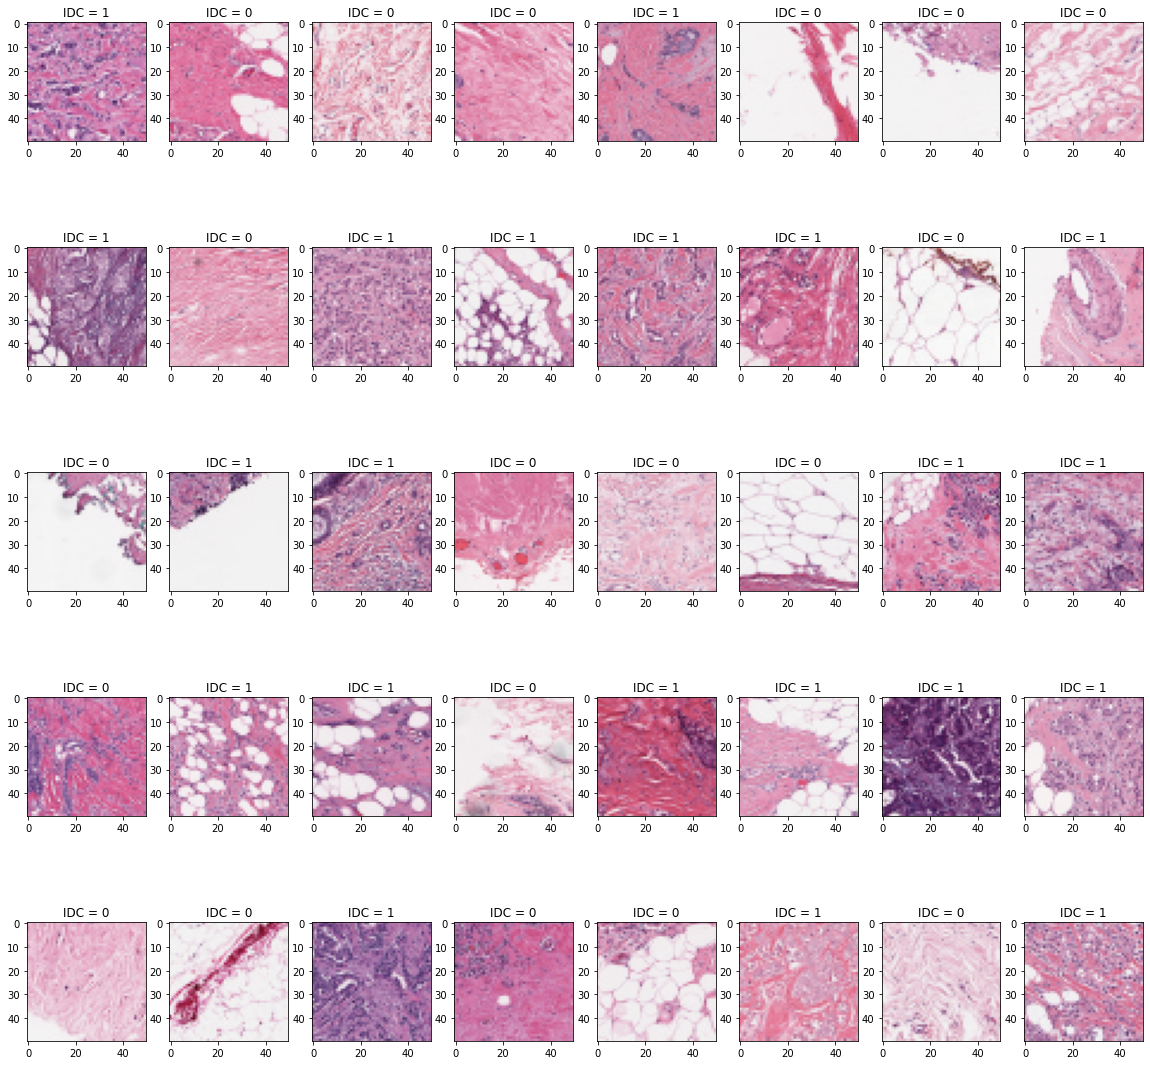

In [5]:
imgs_0 = X[Y == 0] # 0 = not IDC
imgs_1 = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

In [6]:
print('X_images.shape =', X.shape)
print('X_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(X.min(),
                        X.mean(), X.std(), X.max()))
print('')
print('Y_images.shape =', Y.shape)
print('Y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(Y.min(),
                        Y.mean(), Y.std(), Y.max()))

X_images.shape = (5547, 50, 50, 3)
X_images.min/mean/std/max = 2.00/185.03/47.25/255.00

Y_images.shape = (5547,)
Y_images.min/mean/std/max = 0.00/0.50/0.50/1.00


In [7]:
def describeData(a,b):
    
    # images amount
    print('Total number of images: {}'.format(len(a))) 
    # the images amount: IDC is 0
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0))) 
    # the images amount: IDC is 1
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1))) 
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b))) 
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape)) 
    
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


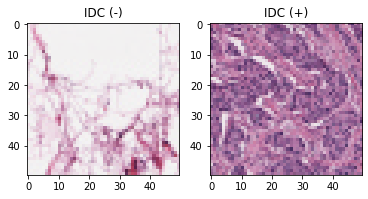

In [8]:
imgs0 = X[Y==0] # (0 = 非IDC, 1 = IDC)
imgs1 = X[Y==1] 

def plotOne(a,b):
    # Random choose a image which IDC is 0
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    # Random choose a image which IDC is 1
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 

### 3. Data processing

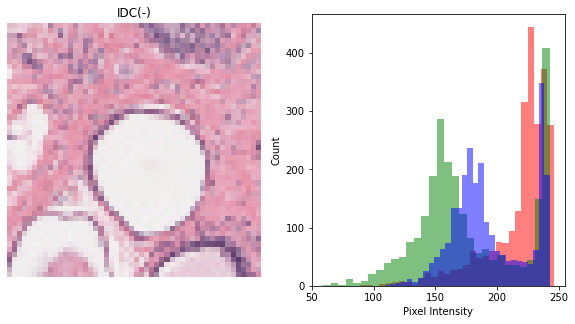

In [9]:
def plotHistogram(a):

    plt.figure(figsize=(10,5))
    
    # Original image
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    # image channel
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5); 
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5); 
    
plotHistogram(X[100])

#### Data split
Choose 20% Data for K-fold cross validation

In [10]:
# Data split and get: training set,test set,corresponding features and tags
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# training sample and testing samples
X_train = X_train[0:30000]  
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

#### Feature Scaling

In [11]:
# Standardize by dividing both the training set and the test set by 256
X_train = X_train / 256.0
X_test = X_test / 256.0

# Check the training set size
print("Training Data Shape:", X_train.shape, Y_train.shape) 

# Check the test set size
print("Testing Data Shape:", X_test.shape, Y_test.shape) 

Training Data Shape: (4437, 50, 50, 3) (4437,)
Testing Data Shape: (1110, 50, 50, 3) (1110,)


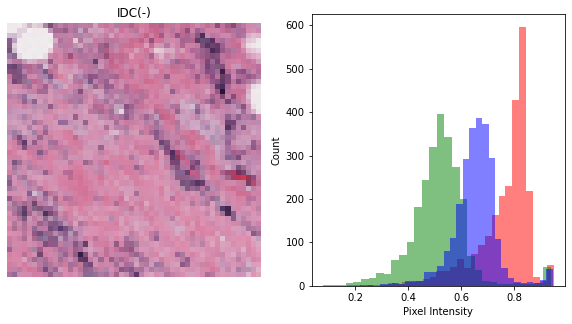

In [12]:
plotHistogram(X_train[100]) 

### 4. Machine Learning method

#### Characteristic flattening

In [13]:
import numpy as np

x_flatten_test = np.arange(135).reshape(5,3,3,3)

print(x_flatten_test)
print("The array dimension is：", x_flatten_test.shape)

[[[[  0   1   2]
   [  3   4   5]
   [  6   7   8]]

  [[  9  10  11]
   [ 12  13  14]
   [ 15  16  17]]

  [[ 18  19  20]
   [ 21  22  23]
   [ 24  25  26]]]


 [[[ 27  28  29]
   [ 30  31  32]
   [ 33  34  35]]

  [[ 36  37  38]
   [ 39  40  41]
   [ 42  43  44]]

  [[ 45  46  47]
   [ 48  49  50]
   [ 51  52  53]]]


 [[[ 54  55  56]
   [ 57  58  59]
   [ 60  61  62]]

  [[ 63  64  65]
   [ 66  67  68]
   [ 69  70  71]]

  [[ 72  73  74]
   [ 75  76  77]
   [ 78  79  80]]]


 [[[ 81  82  83]
   [ 84  85  86]
   [ 87  88  89]]

  [[ 90  91  92]
   [ 93  94  95]
   [ 96  97  98]]

  [[ 99 100 101]
   [102 103 104]
   [105 106 107]]]


 [[[108 109 110]
   [111 112 113]
   [114 115 116]]

  [[117 118 119]
   [120 121 122]
   [123 124 125]]

  [[126 127 128]
   [129 130 131]
   [132 133 134]]]]
数组维度为： (5, 3, 3, 3)


#### length

In [14]:
x_flatten_testShape = x_flatten_test.shape[1]*x_flatten_test.shape[2]*x_flatten_test.shape[3]
x_flatten_testShape

27

#### Data flattening transformation

In [15]:
x_test_flatten_train = x_flatten_test.reshape(x_flatten_test.shape[0], 
                                              x_flatten_testShape)

print(x_test_flatten_train)
print("The array dimension is：", x_test_flatten_train.shape)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26]
 [ 27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
   45  46  47  48  49  50  51  52  53]
 [ 54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80]
 [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
   99 100 101 102 103 104 105 106 107]
 [108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134]]
数组维度为： (5, 27)


In [16]:
# 3 channels into 1 channel
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

#### Logistic regression cross validation

In [17]:
import time

def runLogisticRegression(a,b,c,d):
    
    model = LogisticRegression(solver='lbfgs', max_iter=3000) 
    model.fit(a,b) # train model
    kfold = model_selection.KFold(n_splits=10) # build 10 fold cross calidation
    
    accuracy = model_selection.cross_val_score(model, c,d, 
                                               cv=kfold, scoring='accuracy') 
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    
start = time.time()    
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)
end = time.time()
print('Total time cost is：',end-start, 's')#time cost

LogisticRegression - Training set accuracy: 0.7090090090090089 (0.04302686103156595)

一共花费时间为： 184.4742558002472 秒


#### 6 machine learning method

8min


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.709009 (0.043027)
RF: 0.763964 (0.042790)
KNN: 0.702703 (0.055095)
SVM: 0.773874 (0.044583)
GNB: 0.708108 (0.025861)
DTC: 0.679279 (0.025225)


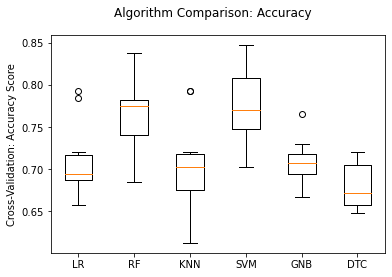

一共花费时间为： 418.07579493522644 秒


In [22]:
# Define the evaluation function of each classification algorithm
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    # Create a list of models and add the respective classifier models used to the list  
    models = []
    # Build logistic regression classifiers: lbfgs
    # maximum iterations: 3000
    models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=3000)))  
    # random forest，weak learners is 100
    models.append(('RF', RandomForestClassifier(n_estimators=100)))  
    # KNN
    models.append(('KNN', KNeighborsClassifier()))     
    # SVM
    models.append(('SVM', SVC(gamma='scale')))            
    # Navie bayes
    models.append(('GNB', GaussianNB()))     
    # decision tree   
    models.append(('DTC', DecisionTreeClassifier()))                            
    resultsAccuracy = [] #save storage classification model name
    names = []#save evaluation indicators for classification models
    # use for loop to train and evaluation each model
    for name, model in models:
        model.fit(a, b) # train model
        kfold = model_selection.KFold(n_splits=10) # build 10-fold cross validation
        # evaluation the model
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy') 
        # result add in resultsAccuracy list
        resultsAccuracy.append(accuracy_results) 
        # result add in names list 
        names.append(name) 
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
    # use box diagram to represent the evaluation of each classifier model
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = plt.subplot(111)
    plt.boxplot(resultsAccuracy)                      # Draw a box diagram
    ax.set_xticklabels(names)                         # Set X-axis to the name of each classifier
    ax.set_ylabel('Cross-Validation: Accuracy Score') # Set the Y-axis name
    plt.show()
    return

start = time.time()  
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)
end = time.time()
print('一共花费时间为：',end-start, '秒')

SVM is better

#### learning curve

About 60min

一共花费时间为： 3194.4496943950653 秒


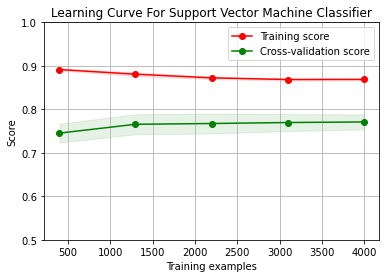

In [23]:
# Define the learning curve function
#estimator: Classifier model
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)             # Set the range of the Y-axis. If not specified, the range is not restricted
    plt.xlabel("Training examples") # x title
    plt.ylabel("Score")             # y title
    
    # earning curve.  Determine cross-validation training and test scores for different training set sizes  
    # https://scikit-learn.org/stable/modules/generated/
    # sklearn.model_selection.learning_curve.html
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1) # Training average
    train_scores_std = np.std(train_scores, axis=1)   # Standard deviation of training score
    test_scores_mean = np.mean(test_scores, axis=1)   # Test average score
    test_scores_std = np.std(test_scores, axis=1)     # Standard deviation of test score
    plt.grid()
    
    # The upper bound is mean training score + standard deviation, and the lower bound is mean training score - standard deviation 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    # The upper bound is mean test score + standard deviation, and the lower bound is mean test score - standard deviation  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    # Draw the curve of the average training score
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Plot changes in average test scores
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best") # Set up the legend and select the best location
    return plt

# Draw the learning curve of support vector machine
def plotLotsOfLearningCurves(a,b):
    models = []
    
    models.append(('Support Vector Machine', SVC(gamma='scale'))) 
    for name, model in models:
        
        # Call the learning curve function to draw the support vector machine learning curve
        plot_learning_curve(model, 
                            'Learning Curve For %s Classifier'% (name), 
                            a,b, (0.5,1), 10)

start = time.time()

# plot        
plotLotsOfLearningCurves(X_trainFlat, Y_train)

end = time.time()
print('Total time cost：',end-start, 's')

### 4.5 Confusion Matrix

In [24]:
# Confusion matrix algroithm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)                           
    plt.colorbar()                             
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=90)    
    plt.yticks(tick_marks, classes)           
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Support Vector Machine - Training set accuracy: 0.7738738738738739 (0.04458321813210314) 



<Figure size 1440x1440 with 0 Axes>

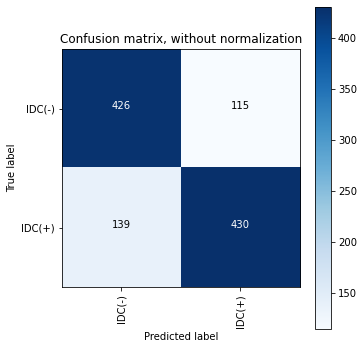

<Figure size 432x288 with 0 Axes>

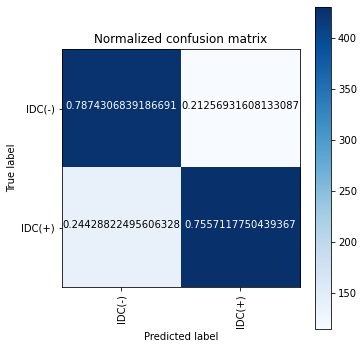

In [25]:
# SVC confusion matrix
def runSVCconfusion(a,b,c,d):

    model = SVC(gamma='scale')                  
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    
    # Calculate cross validation accuracy
    accuracy = model_selection.cross_val_score(model, c,d, 
                                               cv=kfold, scoring='accuracy') 
    mean = accuracy.mean()  # Average accuracy
    stdev = accuracy.std()  # Standard deviation of accuracy
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    
    # Calculate the confusion matrix from the real and predicted values
    cnf_matrix = confusion_matrix(d, prediction) 
    
    # keep 2 decimal
    np.set_printoptions(precision=2) 
    class_names = ["IDC(-)", "IDC(+)"]
    
    # confusion matrix before normalization
    plt.figure(figsize=(20, 20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    
    # confusion matrix after normalization
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)